In [764]:
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import os

os.chdir('/Users/dongthan/Github-Acreadiness/acreadiness/')

# Define the global variable
mainbase = ['SGN', 'HAN', 'DAD', 'CXR', 'HPH','VII','PQC','VCA']

def global_function():
    # Declare 'mainbase' as global
    global mainbase

    # Now you can use 'mainbase' inside this function
    print(mainbase)


In [765]:
def find_min_sta(df, arr):
    # Filter rows where 'ARR' is the specified value
    arr_rows = df[df['ARR'] == arr]

    # Group by 'ACTYPE' and find the index of the minimum 'STA' for each group
    min_sta_index = arr_rows.groupby('ACTYPE')['STA'].idxmin()

    # Use the index to find the corresponding rows
    min_sta_rows = arr_rows.loc[min_sta_index]

    return min_sta_rows

# Function to process flightplan of COM

In [766]:
def assign_actype(ac):
    if 'A321' in ac and 'NEO' in ac and 'ACT' in ac:
        return 'A321-NEO-ACT'
    elif 'A321' in ac and 'NEO' in ac:
        return 'A321-NEO'
    elif 'NEO' in ac and 'A321' not in ac:
        return 'A321-NEO'
    elif 'A321' in ac:
        return 'A321-CEO'
    elif 'A320' in ac:
        return 'A320'
    elif 'A330' in ac:
        return 'A330'
    else:
        return ac

def process_flightplan(filepath):
    # Load data
    df = load_excel_to_dataframe(filepath)
    if df is None:
        return None

    # Preprocess data
    total_row_index = df.loc[df['BASE IN'] == 'OUT'].index[0]
    df = df.loc[:total_row_index]
    df = df.drop(df.index[-1])
    df = df.rename(columns={'Unnamed: 17': 'MORE_INFOR'})

    new_df = df[['AC', 'BASE IN', 'BASE OUT', 'STD', 'ARR', 'ROUTE', 'FLT N0', 'STD.1', 'STA', 'BLOCK','FREQ', 'FROM', 'TO','MORE_INFOR']].copy()
    new_df = new_df.dropna(subset=['AC'])

    # Process 'AC' column
    mask = new_df['MORE_INFOR'].str.contains('NEO|FREEBIRD|ACT', case=False, na=False)
    new_df['AC'] = np.where(mask, new_df['AC'].astype(str) + '-' + new_df['MORE_INFOR'].astype(str), new_df['AC'])

    mask_a321 = (new_df['AC'] == 'A321') & new_df['MORE_INFOR'].isna()
    new_df['AC'] = np.where(mask_a321, new_df['AC'].astype(str) + '-CEO', new_df['AC'])

    mask_a330 = new_df['AC'] != 'A330'
    new_df['AC'] = np.where(~mask & mask_a330, new_df['AC'].astype(str), new_df['AC'])

    mask_remaining = ~new_df['AC'].str.contains('A321|A330|NEO|FREEBIRD|ACT', case=False, na=False)
    new_df['AC'] = np.where(mask_remaining, new_df['AC'].astype(str) + '-A320', new_df['AC'])

    # Assign 'ACTYPE' based on 'AC'
    new_df['ACTYPE'] = new_df['AC'].apply(assign_actype)

    # Rename and reset columns
    new_df = new_df.rename(columns={'STD': 'DEP', 'STD.1': 'STD'})
    new_df.reset_index(drop=True, inplace=True)
    new_df = new_df.drop(columns=['MORE_INFOR'])

    # Determine 'SECTOR'
    start_index = 0
    sector_counter = 1
    for i in range(len(new_df)):
        if new_df.loc[i, 'BASE IN'] in mainbase and pd.isna(new_df.loc[i, 'BASE OUT']):
            if i != 0:
                new_df.loc[start_index:i, 'SECTOR'] = f'Sector {sector_counter}'
                sector_counter += 1
            start_index = i
        elif pd.isna(new_df.loc[i, 'BASE IN']) and new_df.loc[i, 'BASE OUT'] in mainbase:
            new_df.loc[start_index:i+1, 'SECTOR'] = f'Sector {sector_counter}'
            start_index = i + 1
        elif new_df.loc[i, 'BASE IN'] == new_df.loc[i, 'BASE OUT']:
            new_df.loc[start_index:i, 'SECTOR'] = f'Sector {sector_counter}'
            sector_counter += 1
            start_index = i
    if pd.isna(new_df.loc[len(new_df)-1, 'SECTOR']):
        new_df.loc[start_index:, 'SECTOR'] = f'Sector {sector_counter}'

    return new_df

In [767]:
new_df_07 = process_flightplan('7.APR.2024_D7.xlsx')
new_df_08 = process_flightplan('8.APR.2024_D8.xlsx')

In [768]:
display(new_df_07.head(10))
display(new_df_08.head(10))

,AC,BASE IN,BASE OUT,DEP,ARR,ROUTE,FLT N0,STD,STA,BLOCK,FREQ,FROM,TO,ACTYPE,SECTOR
0,27-A321-1-NEO ACT,SGN,NaN,HND,SGN,HND-SGN,VJ821,02:00:00,06:10:00,06:10:00,1234567,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 1
1,27-A321-1-NEO ACT,NaN,NaN,SGN,KHH,SGN-KHH,VJ886,07:30:00,11:40:00,03:10:00,2467,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 1
2,27-A321-1-NEO ACT,NaN,NaN,KHH,SGN,KHH-SGN,VJ885,12:40:00,14:50:00,03:10:00,2467,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 1
3,27-A321-1-NEO ACT,NaN,SGN,SGN,HND,SGN-HND,VJ820,1900-01-23 16:30:00,01:00:00,06:30:00,1234567,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 1
4,38-A321-2-NEO ACT,SGN,NaN,NRT,SGN,NRT-SGN,VJ823,08:55:00,12:55:00,06:00:00,1234567,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 2
5,38-A321-2-NEO ACT,NaN,NaN,SGN,HAN,SGN-HAN,VJ140,14:40:00,16:50:00,02:10:00,1234567,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 2
6,38-A321-2-NEO ACT,NaN,SGN,HAN,SGN,HAN-SGN,VJ149,17:55:00,20:10:00,02:10:00,1234567,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 2
7,28-A321-3-NEO ACT,SGN,NaN,SGN,BKK,SGN-BKK,VJ801,08:35:00,10:05:00,01:30:00,1234567,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 3
8,28-A321-3-NEO ACT,NaN,NaN,BKK,SGN,BKK-SGN,VJ802,11:30:00,13:00:00,01:30:00,1234567,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 3
9,28-A321-3-NEO ACT,NaN,NaN,SGN,HKG,SGN-HKG,VJ876,15:10:00,18:50:00,02:40:00,1;3;5;7,2024-03-31,2024-10-25,A321-NEO-ACT,Sector 3


,AC,BASE IN,BASE OUT,DEP,ARR,ROUTE,FLT N0,STD,STA,BLOCK,FREQ,FROM,TO,ACTYPE,SECTOR
0,27-A321-1-NEO ACT,SGN,NaN,HND,SGN,HND-SGN,VJ821,02:00:00,06:10:00,06:10:00,1234567,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 1
1,27-A321-1-NEO ACT,NaN,NaN,SGN,RMQ,SGN-RMQ,VJ852,07:30:00,11:50:00,03:20:00,135,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 1
2,27-A321-1-NEO ACT,NaN,NaN,RMQ,SGN,RMQ-SGN,VJ853,12:50:00,15:20:00,03:30:00,135,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 1
3,27-A321-1-NEO ACT,NaN,SGN,SGN,HND,SGN-HND,VJ820,1900-01-23 16:30:00,01:00:00,06:30:00,1234567,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 1
4,65-A321-3-NEO ACT,SGN,SGN,SGN,PER,SGN-PER,VJ089,17:15:00,1900-01-24 01:00:00,06:45:00,1;;;5;;,2024-04-08,2024-10-04,A321-NEO-ACT,Sector 2
5,35-A321-4-NEO 4 CYCLES,SGN,NaN,SGN,DPS,SGN-DPS,VJ893,08:15:00,13:05:00,03:50:00,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 3
6,35-A321-4-NEO 4 CYCLES,NaN,NaN,DPS,SGN,DPS-SGN,VJ894,14:05:00,16:55:00,03:50:00,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 3
7,35-A321-4-NEO 4 CYCLES,NaN,NaN,SGN,VCL,SGN-VCL,VJ378,18:00:00,19:20:00,01:20:00,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 3
8,35-A321-4-NEO 4 CYCLES,NaN,SGN,VCL,SGN,VCL-SGN,VJ379,19:55:00,21:20:00,01:20:00,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 3
9,43-A321-5-NEO 4 CYCLES,HAN,NaN,HAN,KIX,HAN-KIX,VJ938,01:20:00,07:50:00,04:30:00,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 4


# Hàm xử lý ngày giờ

In [769]:
### Tính tổng số lượng OUT - IN các station -> cần lưu dữ liệu vào 1 bảng để phân tích
def calculate_and_create_dataframe(df, columns):
    # Calculate counts
    counts = {}
    for column in columns:
        column_counts = df[column].value_counts()
        counts[column] = column_counts

    # Create DataFrame from results
    result_df = pd.DataFrame({
        'STATION': counts[columns[0]].index,
        'OUT': counts[columns[0]].values,
        'IN': counts[columns[1]].reindex(counts[columns[0]].index, fill_value=0).values
    })

    # Calculate total count of 'OUT' and 'IN'
    total_out = result_df['OUT'].sum()
    total_in = result_df['IN'].sum()

    print("Total count of OUT:", total_out)
    print("Total count of IN:", total_in)

    return result_df

## Chuyển đổi format cho cột dữ liệu ngày giờ -> dạng phút

def convert_many_cols_times_to_minutes(df, columns):
    from datetime import datetime, time

    # Define function to convert time to total minutes
    def time_to_minutes(time_obj):
        if isinstance(time_obj, time):
            return time_obj.hour * 60 + time_obj.minute
        elif isinstance(time_obj, datetime):
            return time_obj.hour * 60 + time_obj.minute
        else:
            time_obj = datetime.strptime(time_obj, '%H:%M')
            return time_obj.hour * 60 + time_obj.minute

    # Convert time columns to total minutes
    for column in columns:
        df[column] = df[column].apply(time_to_minutes)

    return df

# Chuyển đổi format cho cột dữ liệu phút -> giờ
def convert_many_cols_minutes_to_hours(df, columns):
    # Define function to convert total minutes to hours
    def minutes_to_hours(minutes):
        hours = minutes // 60
        minutes = minutes % 60
        return f'{int(hours):02d}:{int(minutes):02d}'

    # Convert minutes columns to hours
    for column in columns:
        df[column] = df[column].apply(minutes_to_hours)

    return df
# Chuyển đổi format cho cột dữ liệu phút -> giờ
def convert_single_col_minutes_to_time(df, columns):
    # Define function to convert total minutes to time
    def minutes_to_time(minutes):
        hours = minutes // 60
        minutes = minutes % 60
        return f'{int(hours):02d}:{int(minutes):02d}'

    # Convert columns to time
    for column in columns:
        df[column] = df[column].apply(minutes_to_time)

    return df


In [770]:
new_df_07 = convert_time_columns_to_minutes(new_df_07, ['STD', 'STA','BLOCK'])
new_df_08 = convert_time_columns_to_minutes(new_df_08, ['STD', 'STA','BLOCK'])

In [771]:
display(new_df_07.head(10))
display(new_df_08.head(10))

,AC,BASE IN,BASE OUT,DEP,ARR,ROUTE,FLT N0,STD,STA,BLOCK,FREQ,FROM,TO,ACTYPE,SECTOR
0,27-A321-1-NEO ACT,SGN,NaN,HND,SGN,HND-SGN,VJ821,120,370,370,1234567,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 1
1,27-A321-1-NEO ACT,NaN,NaN,SGN,KHH,SGN-KHH,VJ886,450,700,190,2467,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 1
2,27-A321-1-NEO ACT,NaN,NaN,KHH,SGN,KHH-SGN,VJ885,760,890,190,2467,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 1
3,27-A321-1-NEO ACT,NaN,SGN,SGN,HND,SGN-HND,VJ820,990,60,390,1234567,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 1
4,38-A321-2-NEO ACT,SGN,NaN,NRT,SGN,NRT-SGN,VJ823,535,775,360,1234567,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 2
5,38-A321-2-NEO ACT,NaN,NaN,SGN,HAN,SGN-HAN,VJ140,880,1010,130,1234567,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 2
6,38-A321-2-NEO ACT,NaN,SGN,HAN,SGN,HAN-SGN,VJ149,1075,1210,130,1234567,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 2
7,28-A321-3-NEO ACT,SGN,NaN,SGN,BKK,SGN-BKK,VJ801,515,605,90,1234567,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 3
8,28-A321-3-NEO ACT,NaN,NaN,BKK,SGN,BKK-SGN,VJ802,690,780,90,1234567,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 3
9,28-A321-3-NEO ACT,NaN,NaN,SGN,HKG,SGN-HKG,VJ876,910,1130,160,1;3;5;7,2024-03-31,2024-10-25,A321-NEO-ACT,Sector 3


,AC,BASE IN,BASE OUT,DEP,ARR,ROUTE,FLT N0,STD,STA,BLOCK,FREQ,FROM,TO,ACTYPE,SECTOR
0,27-A321-1-NEO ACT,SGN,NaN,HND,SGN,HND-SGN,VJ821,120,370,370,1234567,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 1
1,27-A321-1-NEO ACT,NaN,NaN,SGN,RMQ,SGN-RMQ,VJ852,450,710,200,135,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 1
2,27-A321-1-NEO ACT,NaN,NaN,RMQ,SGN,RMQ-SGN,VJ853,770,920,210,135,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 1
3,27-A321-1-NEO ACT,NaN,SGN,SGN,HND,SGN-HND,VJ820,990,60,390,1234567,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 1
4,65-A321-3-NEO ACT,SGN,SGN,SGN,PER,SGN-PER,VJ089,1035,60,405,1;;;5;;,2024-04-08,2024-10-04,A321-NEO-ACT,Sector 2
5,35-A321-4-NEO 4 CYCLES,SGN,NaN,SGN,DPS,SGN-DPS,VJ893,495,785,230,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 3
6,35-A321-4-NEO 4 CYCLES,NaN,NaN,DPS,SGN,DPS-SGN,VJ894,845,1015,230,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 3
7,35-A321-4-NEO 4 CYCLES,NaN,NaN,SGN,VCL,SGN-VCL,VJ378,1080,1160,80,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 3
8,35-A321-4-NEO 4 CYCLES,NaN,SGN,VCL,SGN,VCL-SGN,VJ379,1195,1280,80,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 3
9,43-A321-5-NEO 4 CYCLES,HAN,NaN,HAN,KIX,HAN-KIX,VJ938,80,470,270,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 4


### Tính tổng số lượng OUT - IN các station

In [772]:
columns_base_in_out = ['BASE OUT', 'BASE IN']
result_df_07 = calculate_and_create_dataframe(new_df_07, columns_base_in_out)
print(result_df_07)
result_df_08 = calculate_and_create_dataframe(new_df_08, columns_base_in_out)
print(result_df_08)


Total count of OUT: 76
Total count of IN: 76
  STATION  OUT  IN
0     SGN   35  37
1     HAN   22  22
2     CXR   10   8
3     DAD    4   4
4     PQC    3   3
5     VCA    1   1
6     HPH    1   1
Total count of OUT: 75
Total count of IN: 75
  STATION  OUT  IN
0     SGN   37  35
1     HAN   20  21
2     CXR    9  10
3     DAD    4   4
4     PQC    3   3
5     VCA    1   1
6     HPH    1   1


In [878]:
print(result_df_07.columns)

Index(['STATION', 'OUT', 'IN'], dtype='object')


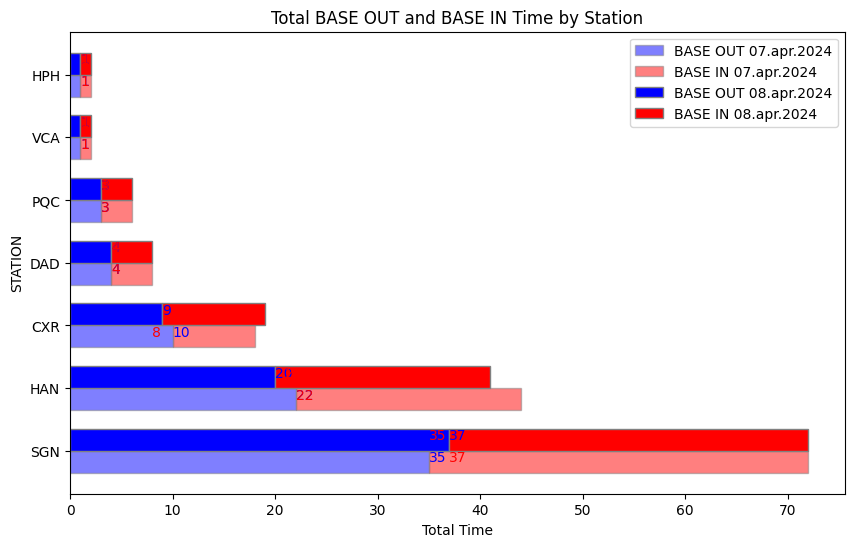

In [885]:
import matplotlib.pyplot as plt

# Define labels
labels = result_df_07.index
stations_07 = result_df_07['STATION'].values
stations_08 = result_df_08['STATION'].values

# Define data
base_out_07 = result_df_07['OUT']
base_in_07 = result_df_07['IN']
base_out_08 = result_df_08['OUT']
base_in_08 = result_df_08['IN']

# Define bar width
bar_width = 0.35

# Define bar positions
r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot data for 07.apr.2024
plt.barh(r1, base_out_07, color='b', height=bar_width, edgecolor='grey', alpha=0.5, label='BASE OUT 07.apr.2024')
plt.barh(r1, base_in_07, left=base_out_07, color='r', height=bar_width, edgecolor='grey', alpha=0.5, label='BASE IN 07.apr.2024')

# Plot data for 08.apr.2024
plt.barh(r2, base_out_08, color='b', height=bar_width, edgecolor='grey', label='BASE OUT 08.apr.2024')
plt.barh(r2, base_in_08, left=base_out_08, color='r', height=bar_width, edgecolor='grey', label='BASE IN 08.apr.2024')

# Add labels and title
plt.ylabel('STATION')
plt.xlabel('Total Time')
plt.title('Total BASE OUT and BASE IN Time by Station')

# Add yticks on the middle of the group bars
plt.yticks([r + bar_width / 2 for r in range(len(base_out_07))], stations_07)

# Add a legend
plt.legend()

# Add total number on top of each bar
for i in range(len(base_out_07)):
    plt.text(x = base_out_07[i] , y = r1[i], s = base_out_07[i], size = 10, color='b')
    plt.text(x = base_in_07[i] , y = r1[i], s = base_in_07[i], size = 10, color='r')

for i in range(len(base_out_08)):
    plt.text(x = base_out_08[i] , y = r2[i], s = base_out_08[i], size = 10, color='b')
    plt.text(x = base_in_08[i] , y = r2[i], s = base_in_08[i], size = 10, color='r')

# Show the plot
plt.show()

## Hàm tính tổng block time của các tàu.
- Sắp xếp và nhóm các tàu ở cột AC theo nhóm
- Sau đó sum các giờ ở cột block time
- Để định dạng giờ ở dạng số để tính toán. Sau khi tính xong sẽ convert sang dạng HH:MM

In [862]:
import datetime

def calculate_total_block_by_ac(df):
    # Convert 'BLOCK' to seconds
    df['BLOCK_seconds'] = df['BLOCK'].apply(lambda t: (datetime.datetime.min + datetime.timedelta(minutes=t)).time().hour*3600 + (datetime.datetime.min + datetime.timedelta(minutes=t)).time().minute*60 + (datetime.datetime.min + datetime.timedelta(minutes=t)).time().second)
    
    # Calculate total 'BLOCK' by 'AC'
    total_block_by_ac = df.groupby('AC')['BLOCK_seconds'].sum()
    
    return total_block_by_ac

# Define function to convert total minutes to 'HH:MM' format (Chuyển từ mins - > HH:MM)
def minutes_to_hhmm(minutes):
    hours, minutes = divmod(minutes, 60)
    return f'{int(hours):02d}:{int(minutes):02d}'



# Use the function
total_block_by_ac_07 = calculate_total_block_by_ac(new_df_07)
# total_block_by_ac_07 = total_block_by_ac_07.apply(minutes_to_hhmm)
print(total_block_by_ac_07)

total_block_by_ac_08 = calculate_total_block_by_ac(new_df_08)
# total_block_by_ac_08 = total_block_by_ac_08.apply(minutes_to_hhmm)
print(total_block_by_ac_08)


AC
1-A320                 39000
11-A320                45600
11-A321                86700
12-4-A320-FREEBIRD     42000
13-A320                35100
                       ...  
8-A320                 22800
80-A321               391500
81-A321                 5100
82-A321                 6000
9-A320                 31200
Name: BLOCK_seconds, Length: 78, dtype: int64
AC
10-A320                47100
11-A321                23700
12-4-A320-FREEBIRD     42000
13-A320                35100
14-13-NEO 4 CYCLES      7800
                       ...  
70-A320                27900
8-3-A320-FREEBIRD       7500
8-A320                 33000
80-A321               180000
81-A321                 7200
Name: BLOCK_seconds, Length: 74, dtype: int64


#### VẼ BIẾU ĐÒ KPI - BLOCK TIME

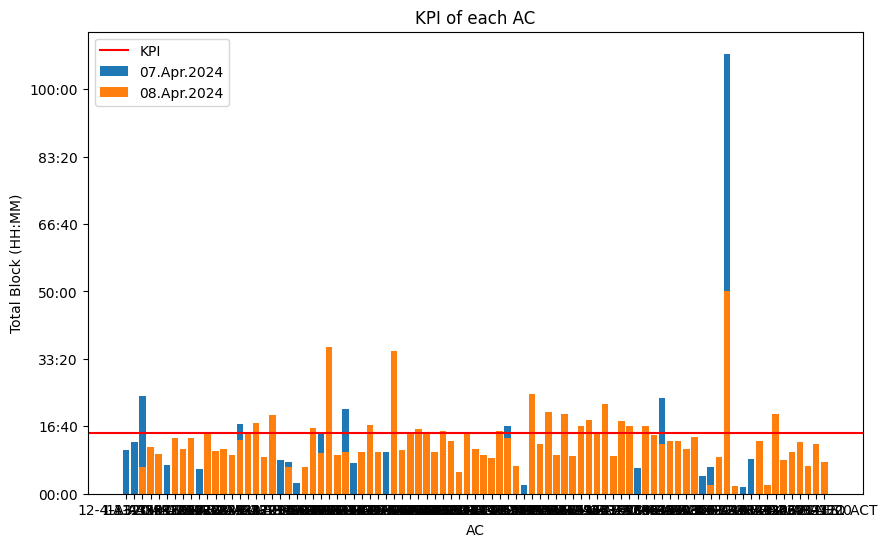

In [864]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Convert total block from seconds to minutes
total_block_by_ac_07_minutes = total_block_by_ac_07 / 60
total_block_by_ac_08_minutes = total_block_by_ac_08 / 60

# Create a new figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot total block for each AC
ax.bar(total_block_by_ac_07_minutes.index, total_block_by_ac_07_minutes, label='07.Apr.2024')
ax.bar(total_block_by_ac_08_minutes.index, total_block_by_ac_08_minutes, label='08.Apr.2024')

# Plot the KPI line
ax.axhline(y=900, color='r', linestyle='-', label='KPI')

# Add labels and title
ax.set_xlabel('AC')
ax.set_ylabel('Total Block (HH:MM)')
ax.set_title('KPI of each AC')

# Format y-axis labels as 'HH:MM'
formatter = ticker.FuncFormatter(lambda x, pos: f'{int(x//60):02d}:{int(x%60):02d}')
ax.yaxis.set_major_formatter(formatter)

# Add a legend
ax.legend()

# Show the plot
plt.show()

## Sau khi tính tổng giờ bay của từng tàu trên ngày ->  Tìm tổng só tàu đạt KPI - 1 ngày khai thac min = 15 hours.
- Sử dụng chỉ số này để tính toán, giải thuật cho việc sắp xếp groundtime

In [774]:
def count_acs_by_block_time(total_block_by_ac, block_time_threshold):
    # Convert block_time_threshold from hours to seconds
    block_time_threshold_seconds = block_time_threshold * 3600

    # Find ACs with BLOCK less than block_time_threshold
    ac_less_than_threshold = total_block_by_ac[total_block_by_ac < block_time_threshold_seconds]

    # Find ACs with BLOCK greater than or equal to block_time_threshold
    ac_greater_equal_threshold = total_block_by_ac[total_block_by_ac >= block_time_threshold_seconds]

    # Count total number of ACs with BLOCK less than block_time_threshold
    total_ac_less_than_threshold = len(ac_less_than_threshold)

    # Count total number of ACs with BLOCK greater than or equal to block_time_threshold
    total_ac_greater_equal_threshold = len(ac_greater_equal_threshold)

    return total_ac_less_than_threshold, total_ac_greater_equal_threshold
# Use the function
total_block_by_ac_07 = calculate_total_block_by_ac(new_df_07)
total_ac_less_than_15h_on_07, total_ac_greater_equal_15h_07 = count_acs_by_block_time(total_block_by_ac_07, 15)

total_block_by_ac_on_08 = calculate_total_block_by_ac(new_df_08)
total_ac_less_than_15h_on_08, total_ac_greater_equal_15h_08 = count_acs_by_block_time(total_block_by_ac_on_08, 15)



print(f"Total ACs with BLOCK < 15 hours on 07.apr.2024: {total_ac_less_than_15h_on_07}")
print(f"Total ACs with BLOCK >= 15 hours on 07.apr.2024: {total_ac_greater_equal_15h_07}")

print(f"Total ACs with BLOCK < 15 hours on.08.apr.2024: {total_ac_less_than_15h_on_08}")
print(f"Total ACs with BLOCK >= 15 hours on.08.apr.2024: {total_ac_greater_equal_15h_08}")

Total ACs with BLOCK < 15 hours on 07.apr.2024: 56
Total ACs with BLOCK >= 15 hours on 07.apr.2024: 22
Total ACs with BLOCK < 15 hours on.08.apr.2024: 51
Total ACs with BLOCK >= 15 hours on.08.apr.2024: 23


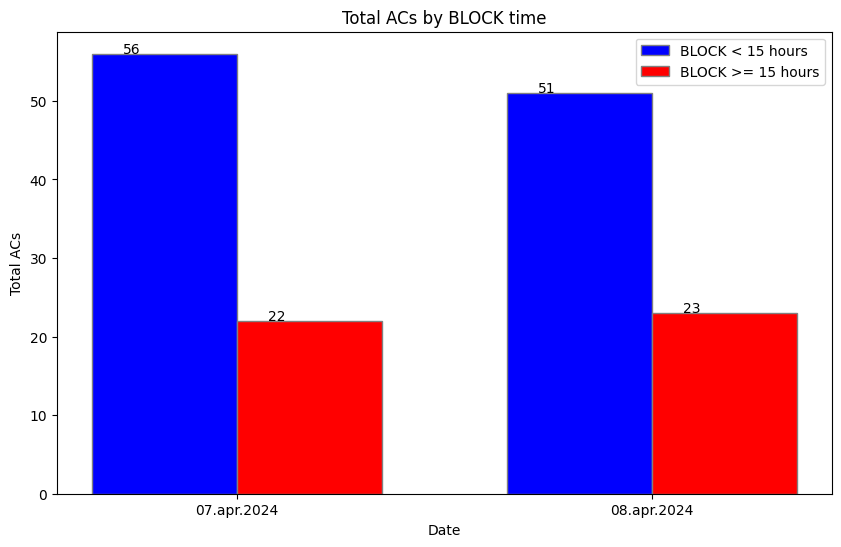

In [866]:
import matplotlib.pyplot as plt
import numpy as np

# Define labels
labels = ['07.apr.2024', '08.apr.2024']

# Define data
less_than_15h = [total_ac_less_than_15h_on_07, total_ac_less_than_15h_on_08]
greater_equal_15h = [total_ac_greater_equal_15h_07, total_ac_greater_equal_15h_08]

# Define bar width
bar_width = 0.35

# Define bar positions
r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot data
plt.bar(r1, less_than_15h, color='b', width=bar_width, edgecolor='grey', label='BLOCK < 15 hours')
plt.bar(r2, greater_equal_15h, color='r', width=bar_width, edgecolor='grey', label='BLOCK >= 15 hours')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Total ACs')
plt.title('Total ACs by BLOCK time')

# Add xticks on the middle of the group bars
plt.xticks([r + bar_width / 2 for r in range(len(less_than_15h))], labels)

# Add a legend
plt.legend()

# Add total number on top of each bar
for i in range(len(less_than_15h)):
    plt.text(x = r1[i]-0.1 , y = less_than_15h[i]+0.1, s = less_than_15h[i], size = 10)
    plt.text(x = r2[i]-0.1 , y = greater_equal_15h[i]+0.1, s = greater_equal_15h[i], size = 10)

# Show the plot
plt.show()

# Đếm số chuyến bay trong mỗi sector

In [775]:
# Có bao nhiêu sector trong new_df_07
df_07_sectors = new_df_07['SECTOR'].unique()
print("Total number of sectors on 07.apr.2024:", len(df_07_sectors))

# Đếm số chuyến bay trong mỗi sector
df_07_sector_counts = new_df_07['SECTOR'].value_counts()
print("Số chuyến bay trong mỗi sector on 07.apr.2024",df_07_sector_counts)

# Tổng số chuyến bay của dataframe new_df_07
df_07_total_flights = len(new_df_07)
print("Total number of flights on 07.apr.2024:", df_07_total_flights)

# Có bao nhiêu sector trong new_df_08
df_08_sectors = new_df_08['SECTOR'].unique()
print("Total number of sectors:", len(df_08_sectors))
# Đếm sô chuyến bay trong mỗi sector
df_08_sector_counts = new_df_08['SECTOR'].value_counts()
print(df_08_sector_counts)

# TỔng số chuyến bay của datafrane new_df_08
df_08_total_flights = len(new_df_08)
print("Total number of flights:", df_08_total_flights)


Total number of sectors on 07.apr.2024: 76
Số chuyến bay trong mỗi sector on 07.apr.2024 SECTOR
Sector 39    8
Sector 29    8
Sector 19    8
Sector 18    8
Sector 17    8
            ..
Sector 9     2
Sector 67    2
Sector 68    2
Sector 10    2
Sector 65    2
Name: count, Length: 76, dtype: int64
Total number of flights on 07.apr.2024: 376
Total number of sectors: 75
SECTOR
Sector 30    8
Sector 28    8
Sector 37    8
Sector 36    8
Sector 26    8
            ..
Sector 65    2
Sector 63    2
Sector 8     2
Sector 12    2
Sector 2     1
Name: count, Length: 75, dtype: int64
Total number of flights: 379


## Dự liệu tổng số chuyến bay theo mỗi loại tàu

In [776]:
# Tổng số chuyến bay của mỗi loại máy bay thực hiện:
print(new_df_07['ACTYPE'].value_counts())
print("------")
print(new_df_08['ACTYPE'].value_counts())

ACTYPE
A321-CEO        161
A320            135
A321-NEO         43
A330             26
A321-NEO-ACT     11
Name: count, dtype: int64
------
ACTYPE
A321-CEO        162
A320            142
A321-NEO         43
A330             27
A321-NEO-ACT      5
Name: count, dtype: int64


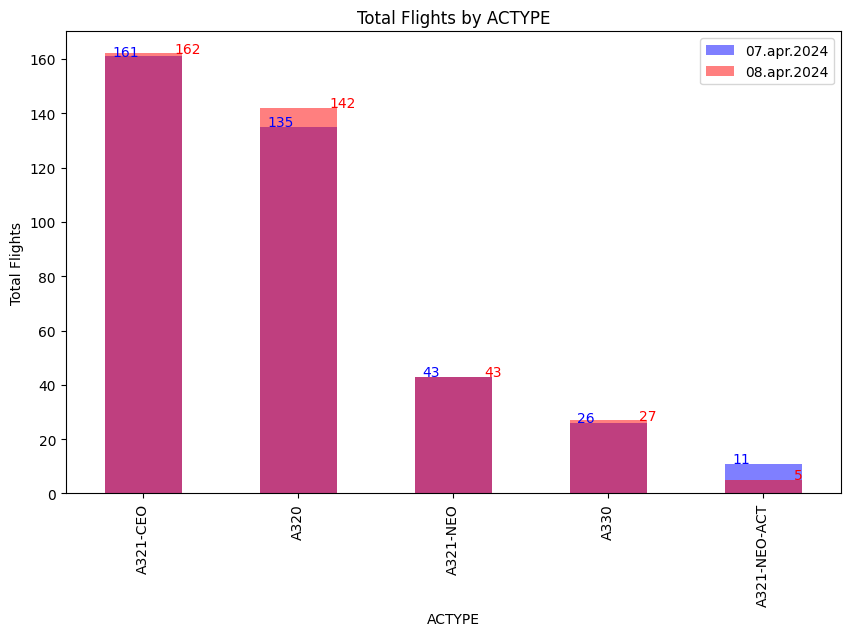

In [869]:
import matplotlib.pyplot as plt

# Get value counts
actype_counts_07 = new_df_07['ACTYPE'].value_counts()
actype_counts_08 = new_df_08['ACTYPE'].value_counts()

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot data
actype_counts_07.plot(kind='bar', color='b', alpha=0.5, label='07.apr.2024')
actype_counts_08.plot(kind='bar', color='r', alpha=0.5, label='08.apr.2024')

# Add labels and title
plt.xlabel('ACTYPE')
plt.ylabel('Total Flights')
plt.title('Total Flights by ACTYPE')

# Add a legend
plt.legend()

# Add total number on top of each bar
for i in range(len(actype_counts_07)):
    plt.text(x = i-0.2 , y = actype_counts_07[i]+0.1, s = actype_counts_07[i], size = 10, color='b')

for i in range(len(actype_counts_08)):
    plt.text(x = i+0.2 , y = actype_counts_08[i]+0.1, s = actype_counts_08[i], size = 10, color='r')

# Show the plot
plt.show()

# Những con số biết nói: Nhìn vào biểu đồ này ta có thể tháy được tần suất sử dụng của từng loại máy bay trong 2 ngày 07 và 08 tháng 4 năm 2024.

## Lọc danh sách các tàu wetlease freebird. Và loại ra khỏi DF. Chỉ lấy những AC của VJ

In [777]:
# Filter rows where 'AC' does not contain 'FREEBIRD' - Danh sách các tàu VJ khai thác
new_df_07_vj_1_without_freebird = new_df_07[~new_df_07['AC'].str.contains('-FREEBIRD')]
new_df_08_vj_1_without_freebird = new_df_08[~new_df_08['AC'].str.contains('-FREEBIRD')]

# Filter rows where 'AC' contains 'FREEBIRD' - Danh sách tàu thuê ướt

new_df_07_vj_1_wetlease = new_df_07[new_df_07['AC'].str.contains('FREEBIRD')]
new_df_08_vj_1_wetlease = new_df_08[new_df_08['AC'].str.contains('FREEBIRD')]

In [778]:
# Tổng số chuyến bay không có FREEBIRD
total_new_df_07_vj_1_without_freebird = new_df_07_vj_1_without_freebird.shape[0]
total_new_df_08_vj_1_without_freebird = new_df_08_vj_1_without_freebird.shape[0]
print("Total number of flights without FREEBIRD on 07.apr.2024:", total_new_df_07_vj_1_without_freebird)
print("Total number of flights without FREEBIRD on 08.apr.2024:", total_new_df_08_vj_1_without_freebird)

# Tổng số chuyến bay có FREEBIRD
total_flights_new_df_07_vj_1_wetlease = len(new_df_07_vj_1_wetlease)
total_flights_new_df_08_vj_1_wetlease = len(new_df_08_vj_1_wetlease)
print("Total number of wetlease flights on 07.apr.2024:", total_flights_new_df_08_vj_1_wetlease)
print("Total number of wetlease flights on 07.apr.2024:", total_flights_new_df_08_vj_1_wetlease)

Total number of flights without FREEBIRD on 07.apr.2024: 348
Total number of flights without FREEBIRD on 08.apr.2024: 353
Total number of wetlease flights on 07.apr.2024: 26
Total number of wetlease flights on 07.apr.2024: 26


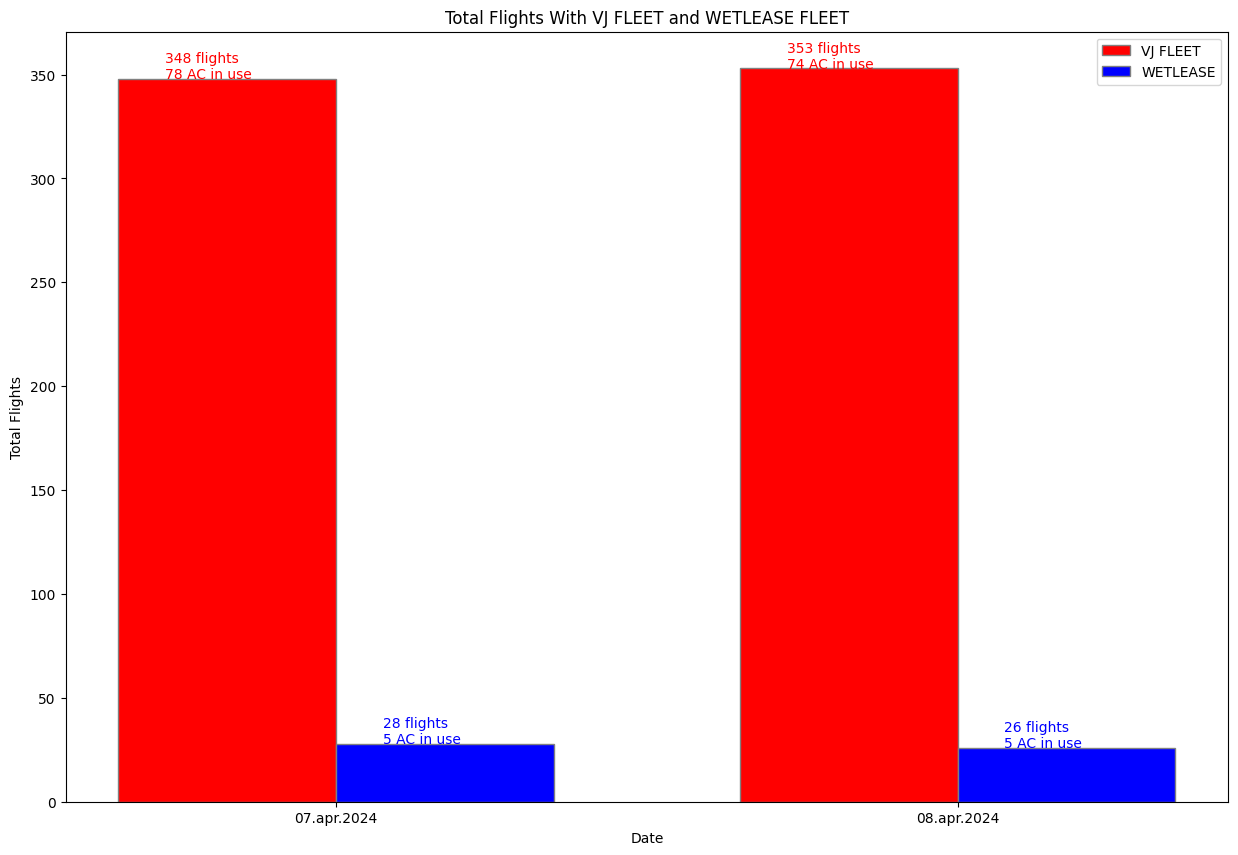

In [874]:
import matplotlib.pyplot as plt

# Define labels
labels = ['07.apr.2024', '08.apr.2024']

# Define data
without_freebird = [total_new_df_07_vj_1_without_freebird, total_new_df_08_vj_1_without_freebird]
with_freebird = [total_flights_new_df_07_vj_1_wetlease, total_flights_new_df_08_vj_1_wetlease]

# Calculate total AC in use
total_ac_in_use_07 = new_df_07['AC'].nunique()
total_ac_in_use_08 = new_df_08['AC'].nunique()
total_ac_in_use_freebird_07 = new_df_07_vj_1_wetlease['AC'].nunique()
total_ac_in_use_freebird_08 = new_df_08_vj_1_wetlease['AC'].nunique()
total_ac_in_use = [total_ac_in_use_07, total_ac_in_use_08]
total_ac_in_use_freebird = [total_ac_in_use_freebird_07, total_ac_in_use_freebird_08]

# Define bar width
bar_width = 0.35

# Define bar positions
r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]

# Create a new figure
plt.figure(figsize=(15, 10))

# Plot data
plt.bar(r1, without_freebird, color='r', width=bar_width, edgecolor='grey', label='VJ FLEET')
plt.bar(r2, with_freebird, color='b', width=bar_width, edgecolor='grey', label='WETLEASE')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Total Flights')
plt.title('Total Flights With VJ FLEET and WETLEASE FLEET')

# Add xticks on the middle of the group bars
plt.xticks([r + bar_width / 2 for r in range(len(without_freebird))], labels)

# Add a legend
plt.legend()

# Add total number on top of each bar
for i in range(len(without_freebird)):
    plt.text(x = r1[i]-0.1 , y = without_freebird[i]+0.1, s = f'{without_freebird[i]} flights\n{total_ac_in_use[i]} AC in use', size = 10, color='r')

for i in range(len(with_freebird)):
    plt.text(x = r2[i]-0.1 , y = with_freebird[i]+0.1, s = f'{with_freebird[i]} flights\n{total_ac_in_use_freebird[i]} AC in use', size = 10, color='b')

# Show the plot
plt.show()

In [779]:
# Group by 'sector' and count unique 'AC' for each group
df_07_num_ac_per_sector = new_df_07_vj_1_without_freebird.groupby('SECTOR')['AC'].nunique()
print(df_07_num_ac_per_sector)
df_08_num_ac_per_sector = new_df_08_vj_1_without_freebird.groupby('SECTOR')['AC'].nunique()
print(df_08_num_ac_per_sector)

# Count unique 'AC' values
df_07_num_unique_ac = new_df_07_vj_1_without_freebird['AC'].nunique()
df_08_num_unique_ac = new_df_08_vj_1_without_freebird['AC'].nunique()

display(df_07_num_unique_ac)
display(df_08_num_unique_ac)

SECTOR
Sector 1     1
Sector 10    1
Sector 11    1
Sector 12    1
Sector 13    1
            ..
Sector 74    1
Sector 75    1
Sector 76    3
Sector 8     1
Sector 9     1
Name: AC, Length: 73, dtype: int64
SECTOR
Sector 1     1
Sector 10    1
Sector 11    1
Sector 12    1
Sector 13    2
            ..
Sector 73    1
Sector 74    1
Sector 75    1
Sector 8     1
Sector 9     1
Name: AC, Length: 72, dtype: int64


73

69

In [780]:
# Filter rows where 'AC' contains 'FREEBIRD'
df_08_freebird_rows = new_df_08[new_df_08['AC'].str.contains('FREEBIRD')]
df_08_vjc_rows = new_df_08[~new_df_08['AC'].str.contains('FREEBIRD')]
# Count unique 'AC' values
num_unique_freebird_df_08 = df_08_freebird_rows['AC'].nunique()
num_vjc_df_08 = df_08_vjc_rows['AC'].nunique()

print(num_unique_freebird_df_08)
print(num_vjc_df_08)

#
df_07_frerbird_rows = new_df_07[new_df_07['AC'].str.contains('FREEBIRD')]
df_07_vjc_rows = new_df_07[~new_df_07['AC'].str.contains('FREEBIRD')]

# Count unique 'AC' values
num_unique_freebird_df_07 = df_07_frerbird_rows['AC'].nunique()
num_vjc_df_07 = df_07_vjc_rows['AC'].nunique()

print(num_unique_freebird_df_07)
print(num_vjc_df_07)

5
69
5
73


# Danh sách tàu bay đầu ngày và tàu về cuối ngày

- Sử dụng df đã lọc FREEBIRD ra khỏi

In [781]:
display(new_df_07_vj_1_without_freebird.head(10))
display(new_df_08_vj_1_without_freebird.head(10))

,AC,BASE IN,BASE OUT,DEP,ARR,ROUTE,FLT N0,STD,STA,BLOCK,FREQ,FROM,TO,ACTYPE,SECTOR,BLOCK_seconds
0,27-A321-1-NEO ACT,SGN,NaN,HND,SGN,HND-SGN,VJ821,120,370,370,1234567,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 1,22200
1,27-A321-1-NEO ACT,NaN,NaN,SGN,KHH,SGN-KHH,VJ886,450,700,190,2467,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 1,11400
2,27-A321-1-NEO ACT,NaN,NaN,KHH,SGN,KHH-SGN,VJ885,760,890,190,2467,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 1,11400
3,27-A321-1-NEO ACT,NaN,SGN,SGN,HND,SGN-HND,VJ820,990,60,390,1234567,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 1,23400
4,38-A321-2-NEO ACT,SGN,NaN,NRT,SGN,NRT-SGN,VJ823,535,775,360,1234567,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 2,21600
5,38-A321-2-NEO ACT,NaN,NaN,SGN,HAN,SGN-HAN,VJ140,880,1010,130,1234567,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 2,7800
6,38-A321-2-NEO ACT,NaN,SGN,HAN,SGN,HAN-SGN,VJ149,1075,1210,130,1234567,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 2,7800
7,28-A321-3-NEO ACT,SGN,NaN,SGN,BKK,SGN-BKK,VJ801,515,605,90,1234567,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 3,5400
8,28-A321-3-NEO ACT,NaN,NaN,BKK,SGN,BKK-SGN,VJ802,690,780,90,1234567,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 3,5400
9,28-A321-3-NEO ACT,NaN,NaN,SGN,HKG,SGN-HKG,VJ876,910,1130,160,1;3;5;7,2024-03-31,2024-10-25,A321-NEO-ACT,Sector 3,9600


,AC,BASE IN,BASE OUT,DEP,ARR,ROUTE,FLT N0,STD,STA,BLOCK,FREQ,FROM,TO,ACTYPE,SECTOR,BLOCK_seconds
0,27-A321-1-NEO ACT,SGN,NaN,HND,SGN,HND-SGN,VJ821,120,370,370,1234567,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 1,22200
1,27-A321-1-NEO ACT,NaN,NaN,SGN,RMQ,SGN-RMQ,VJ852,450,710,200,135,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 1,12000
2,27-A321-1-NEO ACT,NaN,NaN,RMQ,SGN,RMQ-SGN,VJ853,770,920,210,135,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 1,12600
3,27-A321-1-NEO ACT,NaN,SGN,SGN,HND,SGN-HND,VJ820,990,60,390,1234567,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 1,23400
4,65-A321-3-NEO ACT,SGN,SGN,SGN,PER,SGN-PER,VJ089,1035,60,405,1;;;5;;,2024-04-08,2024-10-04,A321-NEO-ACT,Sector 2,24300
5,35-A321-4-NEO 4 CYCLES,SGN,NaN,SGN,DPS,SGN-DPS,VJ893,495,785,230,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 3,13800
6,35-A321-4-NEO 4 CYCLES,NaN,NaN,DPS,SGN,DPS-SGN,VJ894,845,1015,230,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 3,13800
7,35-A321-4-NEO 4 CYCLES,NaN,NaN,SGN,VCL,SGN-VCL,VJ378,1080,1160,80,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 3,4800
8,35-A321-4-NEO 4 CYCLES,NaN,SGN,VCL,SGN,VCL-SGN,VJ379,1195,1280,80,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 3,4800
9,43-A321-5-NEO 4 CYCLES,HAN,NaN,HAN,KIX,HAN-KIX,VJ938,80,470,270,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 4,16200


## Danh sách chuyến bay đầu ngày và chuyến bay cuối ngày ở mainbase và không có chuyến bay đêm

In [782]:

# Filter rows where 'BASE IN' is in 'mainbase ngày 07.apr.2024'
df_07_preflight_mainbase = new_df_07_vj_1_without_freebird[new_df_07_vj_1_without_freebird['BASE IN'].isin(mainbase)]

# Filter rows where 'BASE OUT' is in 'mainbase ngày 07.apr.2024'
df_07_nightstop_mainbase = new_df_07_vj_1_without_freebird[new_df_07_vj_1_without_freebird['BASE OUT'].isin(mainbase)]

# Filter rows where 'BASE IN' is in 'mainbase ngày 08.apr.2024'
df_08_preflight_mainbase = new_df_08_vj_1_without_freebird[new_df_08_vj_1_without_freebird['BASE IN'].isin(mainbase)]

# Filter rows where 'BASE OUT' is in 'mainbase ngày 08.apr.2024'
df_08_nightstop_mainbase = new_df_08_vj_1_without_freebird[new_df_08_vj_1_without_freebird['BASE OUT'].isin(mainbase)]

## --------##
df_07_total_nightstop_mainbase = df_07_nightstop_mainbase.shape[0]
print("Tổng số chuyến bay night stop tại các station ngày 07.apr.2024:",df_07_total_nightstop_mainbase)
df_08_total_nightstop_mainbase = df_08_nightstop_mainbase.shape[0]
print("Tổng số chuyến bay night stop tại các station ngày 08.apr.2024:",df_08_total_nightstop_mainbase)

print("------")

df_07_preflight_mainbase = df_07_preflight_mainbase.shape[0]
print("Tổng số chuyến bay preflight tại các station ngày 07.apr.2024:",df_07_preflight_mainbase)
df_08_total_preflight_mainbase = len(df_08_preflight_mainbase)
print("Tổng số chuyến bay preflight tại các station ngày 08.apr.2024:",df_08_total_preflight_mainbase)

Tổng số chuyến bay night stop tại các station ngày 07.apr.2024: 73
Tổng số chuyến bay night stop tại các station ngày 08.apr.2024: 72
------
Tổng số chuyến bay preflight tại các station ngày 07.apr.2024: 72
Tổng số chuyến bay preflight tại các station ngày 08.apr.2024: 72


## Lọc những chuyến bay không bay tiếp
- Ở col ARR nếu ARR thuộc những station mainbase nghĩa là tàu không bay tiếp.
- Ta lọc những tàu này. = fully_nighstop_in_mainbase

In [783]:
# Filter rows where 'ARR' is in 'mainbase'
fully_nightstop_in_maibase_on_07apr24 = df_07_nightstop_mainbase[df_07_nightstop_mainbase['ARR'].isin(mainbase)]
fully_nightstop_in_maibase_on_08apr24 = df_08_nightstop_mainbase[df_08_nightstop_mainbase['ARR'].isin(mainbase)]


# Đếm tổng số tàu night không bay ở mainbase
total_fully_nightstop_in_mainbas_on_07apr24 = len(fully_nightstop_in_maibase_on_07apr24)
total_fully_nightstop_in_mainbas_on_08apr24 = len(fully_nightstop_in_maibase_on_08apr24)



print("Tổng những tàu night không bay ở mainbase ngày 07.apr.2024:", total_fully_nightstop_in_mainbas_on_07apr24)
print("Tổng số tàu nighstop sẽ bay trong ngày 07.apr.2024:", df_07_total_nightstop_mainbase - total_fully_nightstop_in_mainbas_on_07apr24) # Cần tìm khoảng ground time trước đó để thực hiện bảo dưỡng
print("Tổng những tàu night không bay ở mainbase ngày 08.apr.2024:", total_fully_nightstop_in_mainbas_on_08apr24)
print("Tổng số tàu nighstop sẽ bay trong ngày 08.apr.2024:", df_08_total_nightstop_mainbase - total_fully_nightstop_in_mainbas_on_08apr24)  # Cần tìm khoảng ground time trước đó để thực hiện bảo dưỡng


Tổng những tàu night không bay ở mainbase ngày 07.apr.2024: 55
Tổng số tàu nighstop sẽ bay trong ngày 07.apr.2024: 18
Tổng những tàu night không bay ở mainbase ngày 08.apr.2024: 53
Tổng số tàu nighstop sẽ bay trong ngày 08.apr.2024: 19


In [921]:
fully_nightstop_in_maibase_on_07apr24


,AC,BASE IN,BASE OUT,DEP,ARR,ROUTE,FLT N0,STD,STA,BLOCK,FREQ,FROM,TO,ACTYPE,SECTOR,BLOCK_seconds
6,38-A321-2-NEO ACT,NaN,SGN,HAN,SGN,HAN-SGN,VJ149,1075,1210,130,1234567,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 2,7800
10,28-A321-3-NEO ACT,NaN,SGN,HKG,SGN,HKG-SGN,VJ877,1190,1290,160,1;3;5;7,2024-03-31,2024-10-25,A321-NEO-ACT,Sector 3,9600
14,35-A321-4-NEO 4 CYCLES,NaN,SGN,VCL,SGN,VCL-SGN,VJ379,1195,1280,80,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 4,4800
18,43-A321-5-NEO 4 CYCLES,NaN,HAN,TPE,HAN,TPE-HAN,VJ943,1140,1255,190,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 5,11400
22,45-A321-6-NEO 4 CYCLES,NaN,HAN,KHH,HAN,KHH-HAN,VJ947,1140,1235,155,1357,2024-03-31,2024-10-26,A321-NEO,Sector 6,9300
30,36-A321-12-NEO 4 CYCLES,NaN,SGN,TPE,SGN,TPE-SGN,VJ843,1140,1285,205,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 8,12300
32,37-A321-13-NEO 4 CYCLES,NaN,SGN,ICN,SGN,ICN-SGN,VJ863,700,895,315,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 9,18900
34,46-A321-1-NEO 2 CYCLES,NaN,HAN,NRT,HAN,NRT-HAN,VJ935,990,1205,335,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 10,20100
38,40-A321-7-NEO 4 CYCLES,NaN,SGN,HAN,SGN,HAN-SGN,VJ183,1365,55,130,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 11,7800
42,26-A321-8-NEO 4 CYCLES,NaN,SGN,BKK,SGN,BKK-SGN,VJ806,1195,1285,90,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 12,5400


### Hàm tìm chuyến bay về trễ nhất theo tiêu chí

In [875]:
def find_min_nightst(df, arr):
    # Filter rows where 'ARR' is the specified value
    arr_rows = df[df['ARR'] == arr]

    # Group by 'ACTYPE' and find the index of the minimum 'STA' for each group
    min_sta_index = arr_rows.groupby('ACTYPE')['STA'].idxmin()
   
    # Use the index to find the corresponding rows
    min_sta_rows = arr_rows.loc[min_sta_index]

    return min_sta_rows

def find_min_sta_for_arrs(df, arr_list):
    # Create a dict to store the min STA rows for each ARR
    min_sta_rows_dict = {}
    for arr in arr_list:
        min_sta_rows_dict[arr] = find_min_sta(df, arr)
    
    # Convert dict to DataFrame
    min_sta_rows_df = pd.concat(min_sta_rows_dict.values(), keys=min_sta_rows_dict.keys())

    return min_sta_rows_df

arr_list = ['HAN', 'DAD', 'SGN', 'CXR']

min_nightstop_rows_df_07 = find_min_sta_for_arrs(fully_nightstop_in_maibase_on_07apr24, arr_list)
min_nightstop_rows_df_08 = find_min_sta_for_arrs(fully_nightstop_in_maibase_on_08apr24, arr_list)

print("Tổng những chuyến bay nighstop không bay ở mainbase ngày 07.apr.2024 - Theo tiêu chí Giờ STA nhỏ nhất, phân loại theo ACTYPE: A321-NEO-ACT, A321-NEO, A321-CEO, A320, A330")
# min_sta_rows_df_07 = convert_minutes_to_time(min_sta_rows_df_07, ['STA'])
display(min_nightstop_rows_df_07)
print("------")
print("Tổng những chuyến bay nighstop không bay ở mainbase ngày 08.apr.2024 - Theo tiêu chí Giờ STA nhỏ nhất, phân loại theo ACTYPE: A321-NEO-ACT, A321-NEO, A321-CEO, A320, A330")
# min_sta_rows_df_08 = convert_minutes_to_time(min_sta_rows_df_08, ['STA'])
display(min_nightstop_rows_df_08)

Tổng những chuyến bay nighstop không bay ở mainbase ngày 07.apr.2024 - Theo tiêu chí Giờ STA nhỏ nhất, phân loại theo ACTYPE: A321-NEO-ACT, A321-NEO, A321-CEO, A320, A330


AC BASE IN BASE OUT  DEP  ARR    ROUTE  FLT N0  \
HAN 128                  2-A320     NaN      HAN  SGN  HAN  SGN-HAN   VJ176   
    180                 39-A321     NaN      HAN  SGN  HAN  SGN-HAN   VJ160   
    44   46-A321-2-NEO 2 CYCLES     NaN      HAN  KIX  HAN  KIX-HAN   VJ931   
    360                 67-A330     NaN      HAN  SGN  HAN  SGN-HAN  VJ1164   
DAD 249                 31-A321     NaN      DAD  ICN  DAD  ICN-DAD   VJ875   
SGN 116                 24-A320     NaN      SGN  ICN  SGN  ICN-SGN   VJ861   
    316                 81-A321     NaN      SGN  CXR  SGN  CXR-SGN  VJ1601   
    38   40-A321-7-NEO 4 CYCLES     NaN      SGN  HAN  SGN  HAN-SGN   VJ183   
    6         38-A321-2-NEO ACT     NaN      SGN  HAN  SGN  HAN-SGN   VJ149   
    354                 66-A330     NaN      SGN  HAN  SGN  HAN-SGN   VJ163   
CXR 211                 80-A321     NaN      CXR  NKG  CXR  NKG-CXR  VJ5417   
    348                 64-A330     NaN      CXR  NQZ  CXR  NQZ-CXR   VJ068   

          STD   STA  BLOCK     FREQ       FROM         TO        ACTYPE  \
HAN 128  1315     5    130  1234567 2024-03-31 2024-10-26          A320   
    180  1315     5    130  1234567 2024-03-31 2024-10-26      A321-CEO   
    44    930  1110    300  1234567 2024-03-31 2024-10-26      A321-NEO   
    360  1380    75    130  1234567 2024-03-31 2024-04-25          A330   
DAD 249  1365    85    280  1234567 2024-03-31 2024-10-26      A321-CEO   
SGN 116  1285    40    315  1234567 2024-03-31 2024-10-26          A320   
    316  1355     0     85  1234567 2024-03-31 2024-05-31      A321-CEO   
    38   1365    55    130  1234567 2024-03-31 2024-10-26      A321-NEO   
    6    1075  1210    130  1234567 2024-03-31 2024-10-26  A321-NEO-ACT   
    354  1370    60    130  1234567 2024-03-31 2024-10-26          A330   
CXR 211  1265    15    190      357 2024-03-31 2024-10-26      A321-CEO   
    348  1225   375    520       47 2024-03-31 2024-10-24          A330   

            SECTOR  BLOCK_seconds  
HAN 128  Sector 28           7800  
    180  Sector 36           7800  
    44   Sector 13          18000  
    360  Sector 73           7800  
DAD 249  Sector 48          16800  
SGN 116  Sector 26          18900  
    316  Sector 62           5100  
    38   Sector 11           7800  
    6     Sector 2           7800  
    354  Sector 72           7800  
CXR 211  Sector 41          11400  
    348  Sector 71          31200

------
Tổng những chuyến bay nighstop không bay ở mainbase ngày 08.apr.2024 - Theo tiêu chí Giờ STA nhỏ nhất, phân loại theo ACTYPE: A321-NEO-ACT, A321-NEO, A321-CEO, A320, A330


AC BASE IN BASE OUT  DEP  ARR    ROUTE  FLT N0  \
HAN 113                  2-A320     NaN      HAN  SGN  HAN  SGN-HAN   VJ176   
    367                 69-A321     NaN      HAN  DYG  HAN  DYG-HAN  VJ7867   
    38   46-A321-2-NEO 2 CYCLES     NaN      HAN  KIX  HAN  KIX-HAN   VJ931   
    357                 67-A330     NaN      HAN  SGN  HAN  SGN-HAN  VJ1164   
DAD 252                 31-A321     NaN      DAD  ICN  DAD  ICN-DAD   VJ875   
SGN 226                 24-A320     NaN      SGN  ICN  SGN  ICN-SGN   VJ861   
    155                 31-A321     NaN      SGN  AMD  SGN  AMD-SGN  VJ1806   
    32   40-A321-7-NEO 4 CYCLES     NaN      SGN  HAN  SGN  HAN-SGN   VJ183   
    351                 66-A330     NaN      SGN  HAN  SGN  HAN-SGN   VJ163   
CXR 314                 80-A321     NaN      CXR  HGH  CXR  HGH-CXR  VJ5349   

          STD   STA  BLOCK     FREQ       FROM         TO    ACTYPE  \
HAN 113  1315     5    130  1234567 2024-03-31 2024-10-26      A320   
    367  1335     5    110       15 2024-03-31 2024-06-30  A321-CEO   
    38    930  1110    300  1234567 2024-03-31 2024-10-26  A321-NEO   
    357  1380    75    130  1234567 2024-03-31 2024-04-25      A330   
DAD 252  1365    85    280  1234567 2024-03-31 2024-10-26  A321-CEO   
SGN 226  1275    30    315  1234567 2024-03-31 2024-10-26      A320   
    155  1430   390    310  1234567 2024-03-31 2024-10-26  A321-CEO   
    32   1365    55    130  1234567 2024-03-31 2024-10-26  A321-NEO   
    351  1370    60    130  1234567 2024-03-31 2024-10-26      A330   
CXR 314  1295    20    165     1357 2024-03-31 2024-10-26  A321-CEO   

            SECTOR  BLOCK_seconds  
HAN 113  Sector 25           7800  
    367  Sector 73           6600  
    38   Sector 12          18000  
    357  Sector 71           7800  
DAD 252  Sector 47          16800  
SGN 226  Sector 42          18900  
    155  Sector 31          18600  
    32   Sector 10           7800  
    351  Sector 70           7800  
CXR 314  Sector 60           9900

In [876]:
def filter_preflight_from_mainbase(df, base_in_notna=True, dep_values=None):
    # Filter rows where 'BASE IN' is not empty
    if base_in_notna:
        df = df[df['BASE IN'].notna()]

    # Filter rows where 'DEP' is in dep_values
    if dep_values is not None:
        df = df[df['DEP'].isin(dep_values)]

    return df

# Define a list of values to include
include_values = ['HAN', 'SGN', 'DAD', 'CXR']

# Use the function
df_07_preflight_mainbase_list = filter_preflight_from_mainbase(new_df_07_vj_1_without_freebird, dep_values=include_values)
df_08_preflight_mainbase_list = filter_preflight_from_mainbase(new_df_08_vj_1_without_freebird, dep_values=include_values)

print("Danh sách các chuyến bay preflight có std trễ nhất từ mainbase ngày 07.apr.2024:")
display(df_07_preflight_mainbase_list.head(10))
print("------")

print("Danh sách các chuyến bay preflight có std trễ nhất từ mainbase ngày 08.apr.2024:")

display(df_08_preflight_mainbase_list.head(10))

print("------")
print('Tổng số chuyến bay preflight ngày 07.apr.2024: ',len(df_07_preflight_mainbase_list))
print("Tổng những tàu night không bay ở mainbase ngày 07.apr.2024:", total_fully_nightstop_in_mainbas_on_07apr24)
print("Tổng số tàu nighstop sẽ bay trong ngày 07.apr.2024:", df_07_total_nightstop_mainbase - total_fully_nightstop_in_mainbas_on_07apr24) # Cần tìm khoảng ground time trước đó để thực hiện bảo dưỡng

print('Tổng số chuyến bay preflight ngày 08.apr.2024: ',len(df_08_preflight_mainbase_list))
print("Tổng những tàu night không bay ở mainbase ngày 08.apr.2024:", total_fully_nightstop_in_mainbas_on_08apr24)
print("Tổng số tàu nighstop sẽ bay trong ngày 08.apr.2024:", df_08_total_nightstop_mainbase - total_fully_nightstop_in_mainbas_on_08apr24)

Danh sách các chuyến bay preflight có std trễ nhất từ mainbase ngày 07.apr.2024:


,AC,BASE IN,BASE OUT,DEP,ARR,ROUTE,FLT N0,STD,STA,BLOCK,FREQ,FROM,TO,ACTYPE,SECTOR,BLOCK_seconds
7,28-A321-3-NEO ACT,SGN,NaN,SGN,BKK,SGN-BKK,VJ801,515,605,90,1234567,2024-03-31,2024-10-26,A321-NEO-ACT,Sector 3,5400
11,35-A321-4-NEO 4 CYCLES,SGN,NaN,SGN,DPS,SGN-DPS,VJ893,495,785,230,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 4,13800
15,43-A321-5-NEO 4 CYCLES,HAN,NaN,HAN,KIX,HAN-KIX,VJ938,80,470,270,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 5,16200
19,45-A321-6-NEO 4 CYCLES,HAN,NaN,HAN,NGO,HAN-NGO,VJ920,100,480,295,1;3;5;7,2024-03-31,2024-10-26,A321-NEO,Sector 6,17700
27,36-A321-12-NEO 4 CYCLES,SGN,NaN,SGN,PUS,SGN-PUS,VJ868,55,465,290,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 8,17400
31,37-A321-13-NEO 4 CYCLES,SGN,NaN,SGN,ICN,SGN-ICN,VJ862,155,580,305,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 9,18300
33,46-A321-1-NEO 2 CYCLES,HAN,NaN,HAN,NRT,HAN-NRT,VJ934,475,930,330,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 10,19800
35,40-A321-7-NEO 4 CYCLES,SGN,NaN,SGN,HAN,SGN-HAN,VJ182,300,430,130,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 11,7800
39,26-A321-8-NEO 4 CYCLES,SGN,NaN,SGN,CGK,SGN-CGK,VJ855,575,750,175,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 12,10500
43,46-A321-2-NEO 2 CYCLES,HAN,NaN,HAN,KIX,HAN-KIX,VJ930,475,870,270,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 13,16200


------
Danh sách các chuyến bay preflight có std trễ nhất từ mainbase ngày 08.apr.2024:


,AC,BASE IN,BASE OUT,DEP,ARR,ROUTE,FLT N0,STD,STA,BLOCK,FREQ,FROM,TO,ACTYPE,SECTOR,BLOCK_seconds
4,65-A321-3-NEO ACT,SGN,SGN,SGN,PER,SGN-PER,VJ089,1035,60,405,1;;;5;;,2024-04-08,2024-10-04,A321-NEO-ACT,Sector 2,24300
5,35-A321-4-NEO 4 CYCLES,SGN,NaN,SGN,DPS,SGN-DPS,VJ893,495,785,230,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 3,13800
9,43-A321-5-NEO 4 CYCLES,HAN,NaN,HAN,KIX,HAN-KIX,VJ938,80,470,270,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 4,16200
13,45-A321-6-NEO 4 CYCLES,HAN,NaN,HAN,NGO,HAN-NGO,VJ920,100,480,295,1;3;5;7,2024-03-31,2024-10-26,A321-NEO,Sector 5,17700
21,36-A321-12-NEO 4 CYCLES,SGN,NaN,SGN,PUS,SGN-PUS,VJ868,55,465,290,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 7,17400
25,37-A321-13-NEO 4 CYCLES,SGN,NaN,SGN,ICN,SGN-ICN,VJ862,155,580,305,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 8,18300
27,46-A321-1-NEO 2 CYCLES,HAN,NaN,HAN,NRT,HAN-NRT,VJ934,475,930,330,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 9,19800
29,40-A321-7-NEO 4 CYCLES,SGN,NaN,SGN,HAN,SGN-HAN,VJ182,300,430,130,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 10,7800
33,26-A321-8-NEO 4 CYCLES,SGN,NaN,SGN,CGK,SGN-CGK,VJ855,575,750,175,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 11,10500
37,46-A321-2-NEO 2 CYCLES,HAN,NaN,HAN,KIX,HAN-KIX,VJ930,475,870,270,1234567,2024-03-31,2024-10-26,A321-NEO,Sector 12,16200


------
Tổng số chuyến bay preflight ngày 07.apr.2024:  52
Tổng những tàu night không bay ở mainbase ngày 07.apr.2024: 55
Tổng số tàu nighstop sẽ bay trong ngày 07.apr.2024: 18
Tổng số chuyến bay preflight ngày 08.apr.2024:  53
Tổng những tàu night không bay ở mainbase ngày 08.apr.2024: 53
Tổng số tàu nighstop sẽ bay trong ngày 08.apr.2024: 19


### Tìm chuyến bay đầu ngày có std lớn nhất, theo tiêu chí STATION, ACTYPE

In [786]:
def find_latest_std(df, std):
    # Filter rows where 'DEP' is the specified value
    std_rows = df[df['DEP'] == std]

    # Find the index of the latest 'STD'
    latest_std_index = std_rows.groupby('ACTYPE')['STD'].idxmax()

    # Use the index to find the corresponding row
    latest_std_row = std_rows.loc[latest_std_index]

    return latest_std_row

def find_latest_std_for_std(df, std_list):
    # Create a dict to store the latest STD row for each ACTYPE
    latest_std_rows_dict = {}
    for std in std_list:
        latest_std_rows_dict[std] = find_latest_std(df, std)
    
    # Convert dict to DataFrame
    latest_std_rows_df = pd.concat(latest_std_rows_dict.values(), keys=latest_std_rows_dict.keys())

    return latest_std_rows_df

std_list = ['HAN', 'SGN', 'DAD', 'CXR']
max_preflight_rows_on_07apr2024 = find_latest_std_for_std(df_07_preflight_mainbase_list, std_list)
max_preflight_on_08apr2024 = find_latest_std_for_std(df_08_preflight_mainbase_list, std_list)

In [787]:
display(min_nightstop_rows_df_07)
display(max_preflight_on_08apr2024)  


AC BASE IN BASE OUT  DEP  ARR    ROUTE  FLT N0  \
HAN 128                  2-A320     NaN      HAN  SGN  HAN  SGN-HAN   VJ176   
    180                 39-A321     NaN      HAN  SGN  HAN  SGN-HAN   VJ160   
    44   46-A321-2-NEO 2 CYCLES     NaN      HAN  KIX  HAN  KIX-HAN   VJ931   
    360                 67-A330     NaN      HAN  SGN  HAN  SGN-HAN  VJ1164   
DAD 249                 31-A321     NaN      DAD  ICN  DAD  ICN-DAD   VJ875   
SGN 116                 24-A320     NaN      SGN  ICN  SGN  ICN-SGN   VJ861   
    316                 81-A321     NaN      SGN  CXR  SGN  CXR-SGN  VJ1601   
    38   40-A321-7-NEO 4 CYCLES     NaN      SGN  HAN  SGN  HAN-SGN   VJ183   
    6         38-A321-2-NEO ACT     NaN      SGN  HAN  SGN  HAN-SGN   VJ149   
    354                 66-A330     NaN      SGN  HAN  SGN  HAN-SGN   VJ163   
CXR 211                 80-A321     NaN      CXR  NKG  CXR  NKG-CXR  VJ5417   
    348                 64-A330     NaN      CXR  NQZ  CXR  NQZ-CXR   VJ068   

          STD   STA  BLOCK     FREQ       FROM         TO        ACTYPE  \
HAN 128  1315     5    130  1234567 2024-03-31 2024-10-26          A320   
    180  1315     5    130  1234567 2024-03-31 2024-10-26      A321-CEO   
    44    930  1110    300  1234567 2024-03-31 2024-10-26      A321-NEO   
    360  1380    75    130  1234567 2024-03-31 2024-04-25          A330   
DAD 249  1365    85    280  1234567 2024-03-31 2024-10-26      A321-CEO   
SGN 116  1285    40    315  1234567 2024-03-31 2024-10-26          A320   
    316  1355     0     85  1234567 2024-03-31 2024-05-31      A321-CEO   
    38   1365    55    130  1234567 2024-03-31 2024-10-26      A321-NEO   
    6    1075  1210    130  1234567 2024-03-31 2024-10-26  A321-NEO-ACT   
    354  1370    60    130  1234567 2024-03-31 2024-10-26          A330   
CXR 211  1265    15    190      357 2024-03-31 2024-10-26      A321-CEO   
    348  1225   375    520       47 2024-03-31 2024-10-24          A330   

            SECTOR  BLOCK_seconds  
HAN 128  Sector 28           7800  
    180  Sector 36           7800  
    44   Sector 13          18000  
    360  Sector 73           7800  
DAD 249  Sector 48          16800  
SGN 116  Sector 26          18900  
    316  Sector 62           5100  
    38   Sector 11           7800  
    6     Sector 2           7800  
    354  Sector 72           7800  
CXR 211  Sector 41          11400  
    348  Sector 71          31200

AC BASE IN BASE OUT  DEP  ARR    ROUTE  FLT N0  \
HAN 162                 14-A320     HAN      NaN  HAN  SGN  HAN-SGN   VJ129   
    362                 69-A321     HAN      NaN  HAN  DAD  HAN-DAD   VJ503   
    27   46-A321-1-NEO 2 CYCLES     HAN      NaN  HAN  NRT  HAN-NRT   VJ934   
    352                 67-A330     HAN      NaN  HAN  SGN  HAN-SGN   VJ123   
SGN 238                 29-A320     SGN      NaN  SGN  HKT  SGN-HKT   VJ809   
    374                 31-A321     SGN      NaN  SGN  DAD  SGN-DAD   VJ622   
    33   26-A321-8-NEO 4 CYCLES     SGN      NaN  SGN  CGK  SGN-CGK   VJ855   
    4         65-A321-3-NEO ACT     SGN      SGN  SGN  PER  SGN-PER   VJ089   
    337                 62-A330     SGN      NaN  SGN  BNE  SGN-BNE   VJ083   
DAD 295                 51-A321     DAD      NaN  DAD  PUS  DAD-PUS   VJ988   
CXR 323                 80-A321     CXR      NaN  CXR  UYN  CXR-UYN  VJ5388   
    343                 64-A330     CXR      NaN  CXR  HAN  CXR-HAN   VJ784   

          STD   STA  BLOCK     FREQ       FROM         TO        ACTYPE  \
HAN 162   580   710    130  1234567 2024-03-31 2024-10-26          A320   
    362   385   465     80  1234567 2024-03-31 2024-10-26      A321-CEO   
    27    475   930    330  1234567 2024-03-31 2024-10-26      A321-NEO   
    352   420   550    130  1234567 2024-03-31 2024-10-26          A330   
SGN 238   530   655    115  1234567 2024-03-31 2024-10-26          A320   
    374   425   505     80  1234567 2024-03-31 2024-10-26      A321-CEO   
    33    575   750    175  1234567 2024-03-31 2024-10-26      A321-NEO   
    4    1035    60    405  1;;;5;; 2024-04-08 2024-10-04  A321-NEO-ACT   
    337   640  1315    495  1;3456; 2024-04-01 2024-10-25          A330   
DAD 295   175   540    245  1234567 2024-03-31 2024-10-26      A321-CEO   
CXR 323   740  1080    340     1357 2024-04-01 2024-10-26      A321-CEO   
    343   480   590    110       15 2024-03-31 2024-10-26          A330   

            SECTOR  BLOCK_seconds  
HAN 162  Sector 33           7800  
    362  Sector 73           4800  
    27    Sector 9          19800  
    352  Sector 71           7800  
SGN 238  Sector 45           6900  
    374  Sector 75           4800  
    33   Sector 11          10500  
    4     Sector 2          24300  
    337  Sector 67          29700  
DAD 295  Sector 56          14700  
CXR 323  Sector 63          20400  
    343  Sector 69           6600

In [880]:
# Check number of 'ACTYPE' in min_nightstop_rows_df_07
actype_counts_min_nightstop_rows_df_07 = min_nightstop_rows_df_07['ACTYPE'].value_counts()
print("Number of 'ACTYPE' in min_nightstop_rows_df_07:")
print(actype_counts_min_nightstop_rows_df_07)

# Check number of 'ACTYPE' in max_preflight_on_08apr2024
actype_counts_max_preflight_on_08apr2024 = max_preflight_on_08apr2024['ACTYPE'].value_counts()
print("Number of 'ACTYPE' in max_preflight_on_08apr2024:")
print(actype_counts_max_preflight_on_08apr2024)

Number of 'ACTYPE' in min_nightstop_rows_df_07:
ACTYPE
A321-CEO        4
A330            3
A320            2
A321-NEO        2
A321-NEO-ACT    1
Name: count, dtype: int64
Number of 'ACTYPE' in max_preflight_on_08apr2024:
ACTYPE
A321-CEO        4
A330            3
A320            2
A321-NEO        2
A321-NEO-ACT    1
Name: count, dtype: int64


In [828]:
# Compare the number of rows
num_rows_df1 = min_nightstop_rows_df_07.shape[0]
num_rows_df2 = max_preflight_on_08apr2024.shape[0]
print(f"Number of rows in min_nightstop_rows_df_07: {num_rows_df1}")
print(f"Number of rows in max_preflight_on_08apr2024: {num_rows_df2}")

Number of rows in min_nightstop_rows_df_07: 12
Number of rows in max_preflight_on_08apr2024: 12


In [916]:
# Compare the number of rows
num_rows_df1 = min_nightstop_rows_df_07.shape[0]
num_rows_df2 = max_preflight_on_08apr2024.shape[0]

print(f"Number of rows in min_nightstop_rows_df_07: {num_rows_df1}")
print(f"Number of rows in max_preflight_on_08apr2024: {num_rows_df2}")

def calculate_difference(row):
    if row['STD_y'] < row['STA_x']:
        return row['STD_y'] + 1140 - row['STA_x']
    else:
        return row['STD_y'] - row['STA_x']



# # Merge the two DataFrames on 'ARR' of the first DataFrame and 'DEP' of the second DataFrame
# merged_df = pd.merge(min_nightstop_rows_df_07, max_preflight_on_08apr2024, left_on='ACTYPE', right_on='ACTYPE')

# merged_df = pd.merge(min_nightstop_rows_df_07, max_preflight_on_08apr2024, left_on=['ACTYPE', 'ARR'], right_on=['ACTYPE', 'DEP'])

# merged_df = pd.merge(min_nightstop_rows_df_07, max_preflight_on_08apr2024, on='ACTYPE')
# merged_df = pd.merge(min_nightstop_rows_df_07, max_preflight_on_08apr2024, left_on=['ARR', 'ACTYPE'], right_on=['DEP', 'ACTYPE'])
merged_df_outer = pd.merge(min_nightstop_rows_df_07, max_preflight_on_08apr2024, left_on=['ARR', 'ACTYPE'], right_on=['DEP','ACTYPE'], how='outer')
merged_df_inner = pd.merge(min_nightstop_rows_df_07, max_preflight_on_08apr2024, left_on=['ARR'], right_on=['DEP'], how='inner')

Number of rows in min_nightstop_rows_df_07: 12
Number of rows in max_preflight_on_08apr2024: 12


In [919]:
merged_df_outer


,AC_x,BASE IN_x,BASE OUT_x,DEP_x,ARR_x,ROUTE_x,FLT N0_x,STD_x,STA_x,BLOCK_x,...,ROUTE_y,FLT N0_y,STD_y,STA_y,BLOCK_y,FREQ_y,FROM_y,TO_y,SECTOR_y,BLOCK_seconds_y
0,2-A320,NaN,HAN,SGN,HAN,SGN-HAN,VJ176,1315,5,130,...,HAN-SGN,VJ129,580,710,130,1234567,2024-03-31,2024-10-26,Sector 33,7800
1,39-A321,NaN,HAN,SGN,HAN,SGN-HAN,VJ160,1315,5,130,...,HAN-DAD,VJ503,385,465,80,1234567,2024-03-31,2024-10-26,Sector 73,4800
2,46-A321-2-NEO 2 CYCLES,NaN,HAN,KIX,HAN,KIX-HAN,VJ931,930,1110,300,...,HAN-NRT,VJ934,475,930,330,1234567,2024-03-31,2024-10-26,Sector 9,19800
3,67-A330,NaN,HAN,SGN,HAN,SGN-HAN,VJ1164,1380,75,130,...,HAN-SGN,VJ123,420,550,130,1234567,2024-03-31,2024-10-26,Sector 71,7800
4,31-A321,NaN,DAD,ICN,DAD,ICN-DAD,VJ875,1365,85,280,...,DAD-PUS,VJ988,175,540,245,1234567,2024-03-31,2024-10-26,Sector 56,14700
5,24-A320,NaN,SGN,ICN,SGN,ICN-SGN,VJ861,1285,40,315,...,SGN-HKT,VJ809,530,655,115,1234567,2024-03-31,2024-10-26,Sector 45,6900
6,81-A321,NaN,SGN,CXR,SGN,CXR-SGN,VJ1601,1355,0,85,...,SGN-DAD,VJ622,425,505,80,1234567,2024-03-31,2024-10-26,Sector 75,4800
7,40-A321-7-NEO 4 CYCLES,NaN,SGN,HAN,SGN,HAN-SGN,VJ183,1365,55,130,...,SGN-CGK,VJ855,575,750,175,1234567,2024-03-31,2024-10-26,Sector 11,10500
8,38-A321-2-NEO ACT,NaN,SGN,HAN,SGN,HAN-SGN,VJ149,1075,1210,130,...,SGN-PER,VJ089,1035,60,405,1;;;5;;,2024-04-08,2024-10-04,Sector 2,24300
9,66-A330,NaN,SGN,HAN,SGN,HAN-SGN,VJ163,1370,60,130,...,SGN-BNE,VJ083,640,1315,495,1;3456;,2024-04-01,2024-10-25,Sector 67,29700


In [918]:
merged_df_outer.to_excel('merged_df_outer.xlsx', index=False)

In [911]:
# Merge two dataframes based on conditions
merged_df = pd.merge(min_nightstop_rows_df_07, max_preflight_on_08apr2024, 
                     left_on=['ARR', 'ACTYPE'], 
                     right_on=['DEP', 'ACTYPE'], 
                     how='inner')

# Print the merged dataframe
display(merged_df)

,AC_x,BASE IN_x,BASE OUT_x,DEP_x,ARR_x,ROUTE_x,FLT N0_x,STD_x,STA_x,BLOCK_x,...,ROUTE_y,FLT N0_y,STD_y,STA_y,BLOCK_y,FREQ_y,FROM_y,TO_y,SECTOR_y,BLOCK_seconds_y
0,2-A320,NaN,HAN,SGN,HAN,SGN-HAN,VJ176,1315,5,130,...,HAN-SGN,VJ129,580,710,130,1234567,2024-03-31,2024-10-26,Sector 33,7800
1,39-A321,NaN,HAN,SGN,HAN,SGN-HAN,VJ160,1315,5,130,...,HAN-DAD,VJ503,385,465,80,1234567,2024-03-31,2024-10-26,Sector 73,4800
2,46-A321-2-NEO 2 CYCLES,NaN,HAN,KIX,HAN,KIX-HAN,VJ931,930,1110,300,...,HAN-NRT,VJ934,475,930,330,1234567,2024-03-31,2024-10-26,Sector 9,19800
3,67-A330,NaN,HAN,SGN,HAN,SGN-HAN,VJ1164,1380,75,130,...,HAN-SGN,VJ123,420,550,130,1234567,2024-03-31,2024-10-26,Sector 71,7800
4,31-A321,NaN,DAD,ICN,DAD,ICN-DAD,VJ875,1365,85,280,...,DAD-PUS,VJ988,175,540,245,1234567,2024-03-31,2024-10-26,Sector 56,14700
5,24-A320,NaN,SGN,ICN,SGN,ICN-SGN,VJ861,1285,40,315,...,SGN-HKT,VJ809,530,655,115,1234567,2024-03-31,2024-10-26,Sector 45,6900
6,81-A321,NaN,SGN,CXR,SGN,CXR-SGN,VJ1601,1355,0,85,...,SGN-DAD,VJ622,425,505,80,1234567,2024-03-31,2024-10-26,Sector 75,4800
7,40-A321-7-NEO 4 CYCLES,NaN,SGN,HAN,SGN,HAN-SGN,VJ183,1365,55,130,...,SGN-CGK,VJ855,575,750,175,1234567,2024-03-31,2024-10-26,Sector 11,10500
8,38-A321-2-NEO ACT,NaN,SGN,HAN,SGN,HAN-SGN,VJ149,1075,1210,130,...,SGN-PER,VJ089,1035,60,405,1;;;5;;,2024-04-08,2024-10-04,Sector 2,24300
9,66-A330,NaN,SGN,HAN,SGN,HAN-SGN,VJ163,1370,60,130,...,SGN-BNE,VJ083,640,1315,495,1;3456;,2024-04-01,2024-10-25,Sector 67,29700


In [913]:
merged_df.to_excel('merged_df.xlsx', index=False)

In [912]:

print(merged_df.columns)
merged_df['GRD_TIME'] = merged_df.apply(calculate_difference, axis=1)

select_column = ['AC_x','DEP_x', 'ARR_x','FLT N0_x','STD_x','STA_x','ACTYPE_x','AC_y','DEP_y','ARR_y','FLT N0_y','STD_y','STA_y','ACTYPE_y','GRD_TIME']
df_compare = merged_df[select_column].copy()
df_compare = convert_many_cols_minutes_to_hours(df_compare, ['GRD_TIME','STD_x','STA_x','STA_y','STD_y'])
display(df_compare.head(10))

Index(['AC_x', 'BASE IN_x', 'BASE OUT_x', 'DEP_x', 'ARR_x', 'ROUTE_x',
       'FLT N0_x', 'STD_x', 'STA_x', 'BLOCK_x', 'FREQ_x', 'FROM_x', 'TO_x',
       'ACTYPE', 'SECTOR_x', 'BLOCK_seconds_x', 'AC_y', 'BASE IN_y',
       'BASE OUT_y', 'DEP_y', 'ARR_y', 'ROUTE_y', 'FLT N0_y', 'STD_y', 'STA_y',
       'BLOCK_y', 'FREQ_y', 'FROM_y', 'TO_y', 'SECTOR_y', 'BLOCK_seconds_y'],
      dtype='object')


KeyError: "['ACTYPE_x', 'ACTYPE_y'] not in index"

In [903]:
# Export df_compare to Excel
df_compare.to_excel("df_compare.xlsx", index=False)
min_nightstop_rows_df_07.to_excel("min_nightstop_rows_df_07.xlsx", index=False)
max_preflight_on_08apr2024.to_excel("max_preflight_on_08apr2024.xlsx", index=False)

In [906]:
def prepare_and_convert_time(df, calculate_difference, convert_func, select_columns, time_columns):
    df['GRD_TIME'] = df.apply(calculate_difference, axis=1)

    df_selected = df[select_columns].copy()
    df_converted = convert_func(df_selected, time_columns)

    return df_converted

# Usage:
select_column = ['AC_x','DEP_x', 'ARR_x','FLT N0_x','STD_x','STA_x','ACTYPE_x','AC_y','DEP_y','ARR_y','FLT N0_y','STD_y','STA_y','ACTYPE_y','GRD_TIME']
time_columns = ['GRD_TIME','STD_x','STA_x','STA_y','STD_y']
df_compare1 = prepare_and_convert_time(merged_df_inner, calculate_difference, convert_many_cols_minutes_to_hours, select_column, time_columns)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


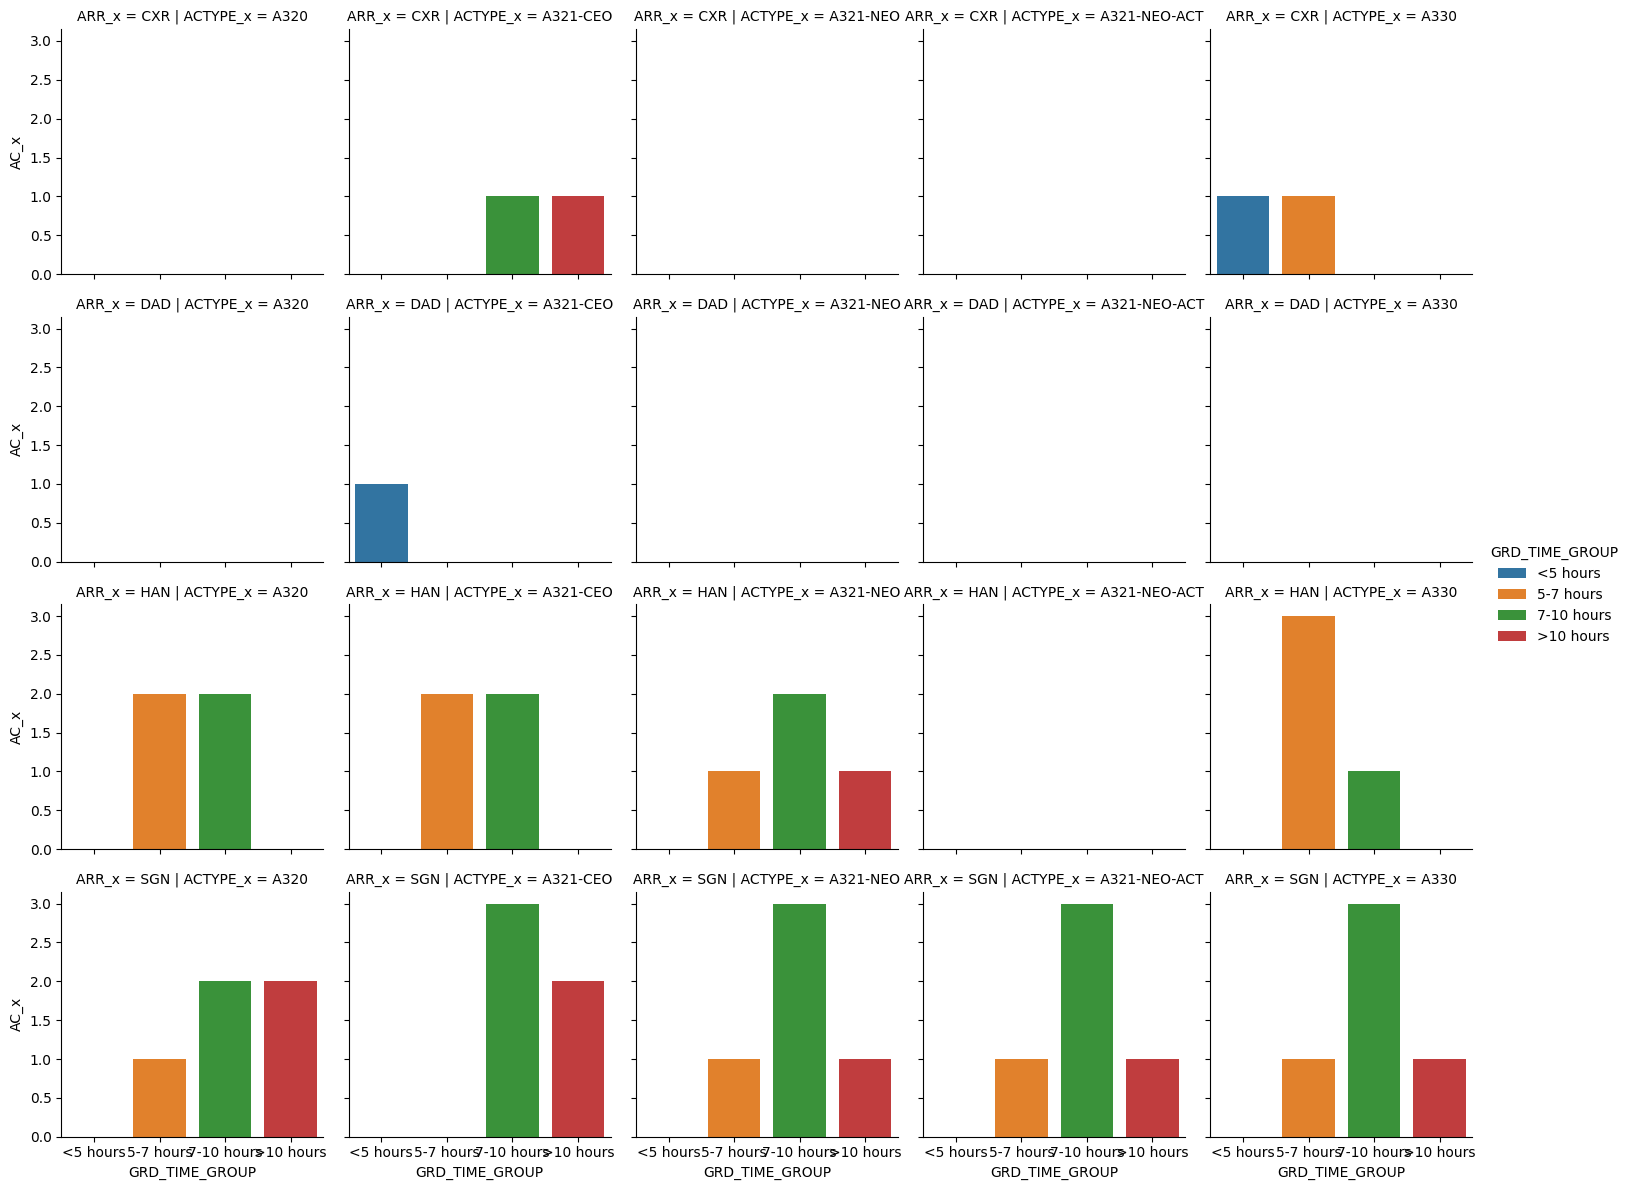

In [899]:
# Convert 'GRD_TIME' to numeric
df_compare['GRD_TIME'] = pd.to_datetime(df_compare['GRD_TIME'], format='%H:%M').dt.hour

# Define bins for 'GRD_TIME'
bins = [0, 5, 7, 10, float('inf')]

# Define labels for 'GRD_TIME'
labels = ['<5 hours', '5-7 hours', '7-10 hours', '>10 hours']

# Create 'GRD_TIME_GROUP' column
df_compare['GRD_TIME_GROUP'] = pd.cut(df_compare['GRD_TIME'], bins=bins, labels=labels, right=False)

# Group by 'ARR_x', 'ACTYPE_x', and 'GRD_TIME_GROUP' and count the number of AC
grouped = df_compare.groupby(['ARR_x', 'ACTYPE_x', 'GRD_TIME_GROUP'])['AC_x'].count().reset_index()

# Create a FacetGrid
g = sns.FacetGrid(grouped, col="ACTYPE_x", row="ARR_x", hue="GRD_TIME_GROUP", legend_out=True)

# Map a bar plot
g.map(sns.barplot, "GRD_TIME_GROUP", "AC_x")

# Add a legend
g.add_legend()

# Show the plot
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


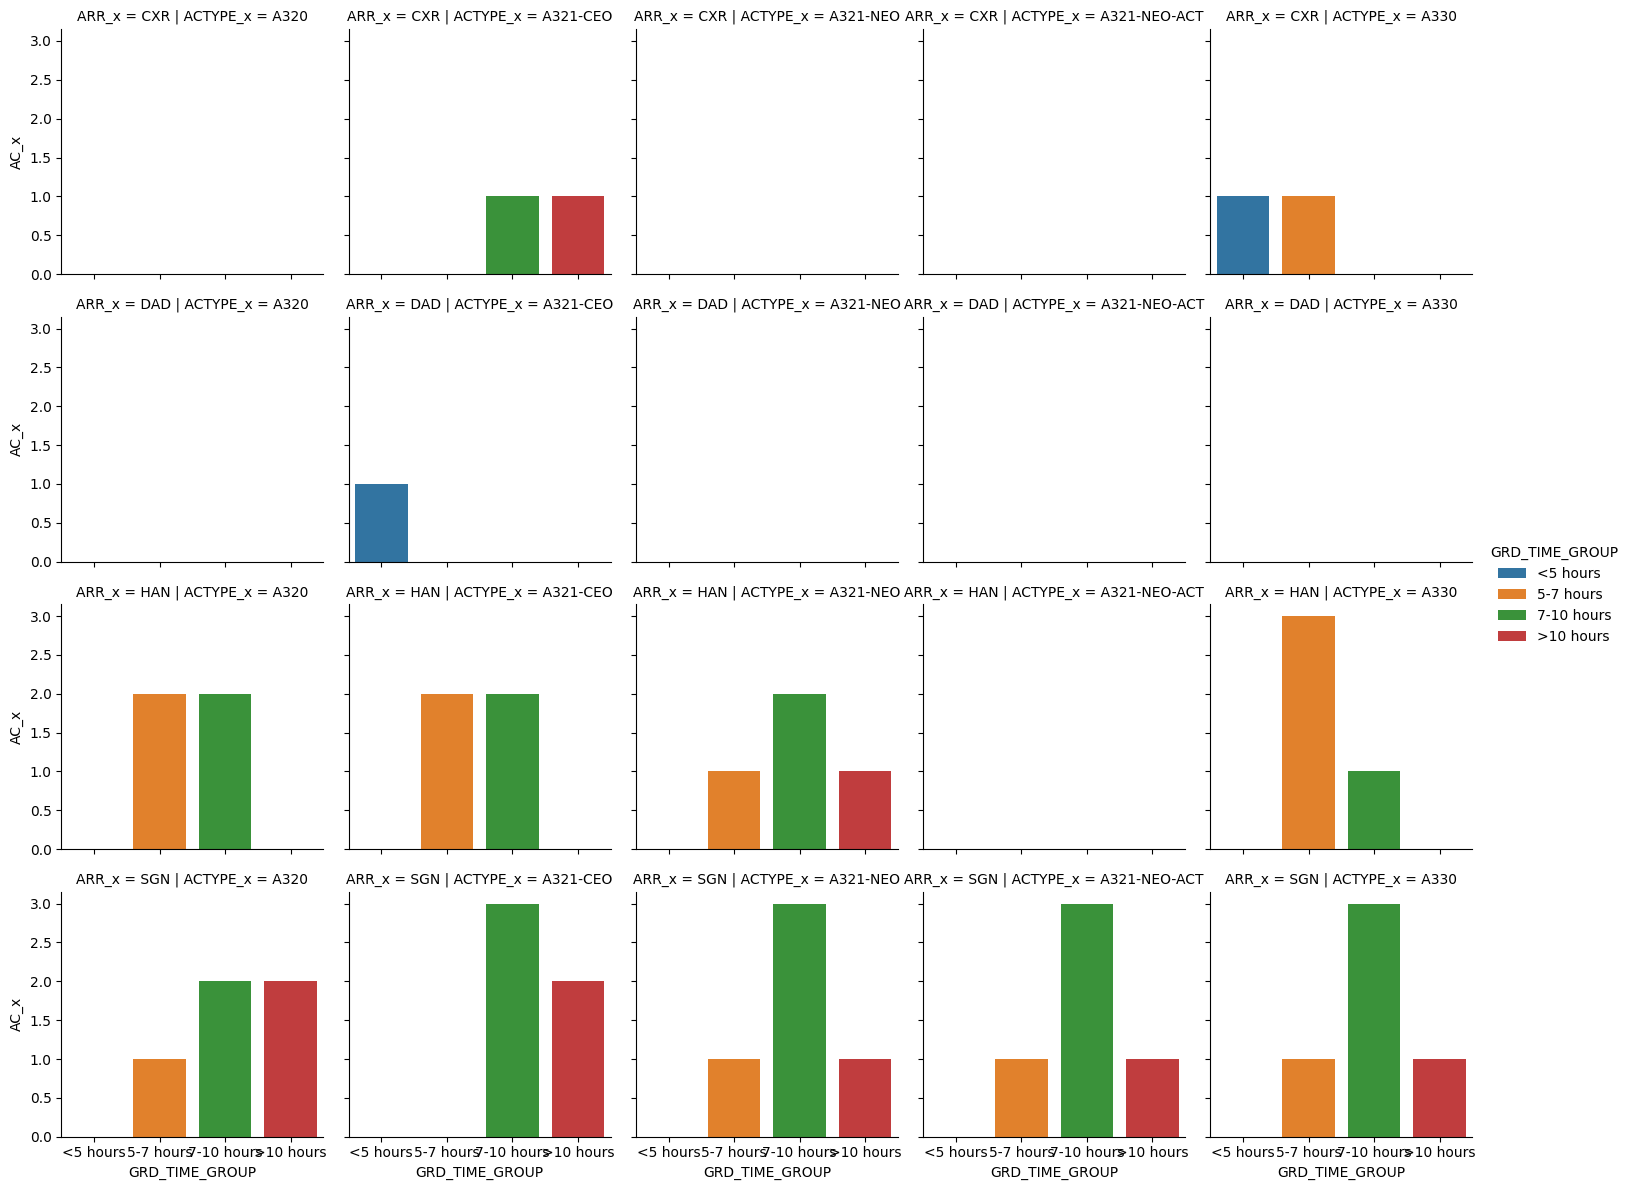

In [907]:

df_compare1['GRD_TIME'] = pd.to_datetime(df_compare1['GRD_TIME'], format='%H:%M').dt.hour

# Define bins for 'GRD_TIME'
bins = [0, 5, 7, 10, float('inf')]

# Define labels for 'GRD_TIME'
labels = ['<5 hours', '5-7 hours', '7-10 hours', '>10 hours']

# Create 'GRD_TIME_GROUP' column
df_compare1['GRD_TIME_GROUP'] = pd.cut(df_compare1['GRD_TIME'], bins=bins, labels=labels, right=False)

# Group by 'ARR_x', 'ACTYPE_x', and 'GRD_TIME_GROUP' and count the number of AC
grouped = df_compare1.groupby(['ARR_x', 'ACTYPE_x', 'GRD_TIME_GROUP'])['AC_x'].count().reset_index()

# Create a FacetGrid
g = sns.FacetGrid(grouped, col="ACTYPE_x", row="ARR_x", hue="GRD_TIME_GROUP", legend_out=True)

# Map a bar plot
g.map(sns.barplot, "GRD_TIME_GROUP", "AC_x")

# Add a legend
g.add_legend()

# Show the plot
plt.show()

In [908]:
df_compare1

,AC_x,DEP_x,ARR_x,FLT N0_x,STD_x,STA_x,ACTYPE_x,AC_y,DEP_y,ARR_y,FLT N0_y,STD_y,STA_y,ACTYPE_y,GRD_TIME,GRD_TIME_GROUP
0,2-A320,SGN,HAN,VJ176,21:55,00:05,A320,14-A320,HAN,SGN,VJ129,09:40,11:50,A320,9,7-10 hours
1,2-A320,SGN,HAN,VJ176,21:55,00:05,A320,69-A321,HAN,DAD,VJ503,06:25,07:45,A321-CEO,6,5-7 hours
2,2-A320,SGN,HAN,VJ176,21:55,00:05,A320,46-A321-1-NEO 2 CYCLES,HAN,NRT,VJ934,07:55,15:30,A321-NEO,7,7-10 hours
3,2-A320,SGN,HAN,VJ176,21:55,00:05,A320,67-A330,HAN,SGN,VJ123,07:00,09:10,A330,6,5-7 hours
4,39-A321,SGN,HAN,VJ160,21:55,00:05,A321-CEO,14-A320,HAN,SGN,VJ129,09:40,11:50,A320,9,7-10 hours
5,39-A321,SGN,HAN,VJ160,21:55,00:05,A321-CEO,69-A321,HAN,DAD,VJ503,06:25,07:45,A321-CEO,6,5-7 hours
6,39-A321,SGN,HAN,VJ160,21:55,00:05,A321-CEO,46-A321-1-NEO 2 CYCLES,HAN,NRT,VJ934,07:55,15:30,A321-NEO,7,7-10 hours
7,39-A321,SGN,HAN,VJ160,21:55,00:05,A321-CEO,67-A330,HAN,SGN,VJ123,07:00,09:10,A330,6,5-7 hours
8,46-A321-2-NEO 2 CYCLES,KIX,HAN,VJ931,15:30,18:30,A321-NEO,14-A320,HAN,SGN,VJ129,09:40,11:50,A320,10,>10 hours
9,46-A321-2-NEO 2 CYCLES,KIX,HAN,VJ931,15:30,18:30,A321-NEO,69-A321,HAN,DAD,VJ503,06:25,07:45,A321-CEO,6,5-7 hours
